This is the tutorial of **Image Clustering**
<br>
If you want to skip the **training** phase, please refer to the **clustering** section directly.
<br>
**Training** required sections:  Prepare Training Data, Model, Training
<br>
**Clustering** required sections: Prepare Training Data, Model, Dimension Reduction & Clustering

同學們也可以利用提供的wget指令下載訓練資料，並自行mount到雲端資料夾上，如作業一所示。這邊就不再贅述<br>
作業的第一部分是要訓練一個autoencoder以抽取好的圖片表徵，第二部分則是將抽出來的表徵降維到二維，以便我們利用分群的方法獲得我們的答案<br>

若有任何問題，歡迎來信至助教信箱 ntu-ml-2020spring-ta@googlegroups.com

# Download Dataset

In [0]:
!gdown --id '1BZb2AqOHHaad7Mo82St1qTBaXo_xtcUc' --output trainX.npy 
!gdown --id '152NKCpj8S_zuIx3bQy0NN5oqpvBjdPIq' --output valX.npy 
!gdown --id '1_hRGsFtm5KEazUg2ZvPZcuNScGF-ANh4' --output valY.npy 
!mkdir checkpoints
!ls

Downloading...
From: https://drive.google.com/uc?id=1BZb2AqOHHaad7Mo82St1qTBaXo_xtcUc
To: /content/trainX.npy
26.1MB [00:00, 158MB/s]
Downloading...
From: https://drive.google.com/uc?id=152NKCpj8S_zuIx3bQy0NN5oqpvBjdPIq
To: /content/valX.npy
100% 1.54M/1.54M [00:00<00:00, 102MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_hRGsFtm5KEazUg2ZvPZcuNScGF-ANh4
To: /content/valY.npy
100% 4.13k/4.13k [00:00<00:00, 6.54MB/s]
checkpoints  sample_data  trainX.npy  valX.npy	valY.npy


# Prepare Training Data

定義我們的 preprocess：將圖片的數值介於 0~255 的 int 線性轉為 -1～1 的 float。

In [0]:
import numpy as np

def preprocess(image_list):
    """ Normalize Image and Permute (N,H,W,C) to (N,C,H,W)
    Args:
      image_list: List of images (9000, 32, 32, 3)
    Returns:
      image_list: List of images (9000, 3, 32, 32)
    """
    image_list = np.array(image_list)
    image_list = np.transpose(image_list, (0, 3, 1, 2))
    image_list = (image_list / 255.0) * 2 - 1
    image_list = image_list.astype(np.float32)
    return image_list

In [0]:
from torch.utils.data import Dataset

class Image_Dataset(Dataset):
    def __init__(self, image_list):
        self.image_list = image_list
    def __len__(self):
        return len(self.image_list)
    def __getitem__(self, idx):
        images = self.image_list[idx]
        return images

將訓練資料讀入，並且 preprocess。
之後我們將 preprocess 完的訓練資料變成我們需要的 dataset。請同學不要使用 valX 和 valY 來訓練。

In [0]:
from torch.utils.data import DataLoader

trainX = np.load('trainX.npy')
trainX_preprocessed = preprocess(trainX)
img_dataset = Image_Dataset(trainX_preprocessed)

# Some useful functions


這邊提供一些有用的 functions。
一個是計算 model 參數量的（report 會用到），另一個是固定訓練的隨機種子（以便 reproduce）。

In [0]:
import random
import torch

def count_parameters(model, only_trainable=False):
    if only_trainable:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in model.parameters())

def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


# Model

定義我們的 baseline autoeocoder。

In [0]:
import torch.nn as nn

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        
        self.encoder = nn.Sequential(         # input 3 32 32
            nn.Conv2d(3, 64, 3, stride=1, padding=1),  # 64, 32, 32
            nn.ReLU(True),
            nn.MaxPool2d(2),                # 64, 16, 16
            nn.Conv2d(64, 128, 3, stride=1, padding=1), # 128, 16, 16
            nn.ReLU(True), 
            nn.MaxPool2d(2),                # 128, 8, 8
            nn.Conv2d(128, 256, 3, stride=1, padding=1),# 256, 8, 8
            nn.ReLU(True),
            nn.MaxPool2d(2)                 # 256, 4, 4
        )
 
        self.decoder = nn.Sequential(
            # out = (in - 1) * stride - 2 * padding + kernel_size
            nn.ConvTranspose2d(256, 128, 5, stride=1), # 128 8 8
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 9, stride=1), # 64 16 16 
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 17, stride=1),  # 3 32 32
            nn.Tanh() # 使用tanh保留完整值域
        )

    def forward(self, x):
        x1 = self.encoder(x)
        x  = self.decoder(x1)
        return x1, x

In [0]:
!nvidia-smi

Wed May 20 02:40:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Training

這個部分就是主要的訓練階段。
我們先將準備好的 dataset 當作參數餵給 dataloader。
將 dataloader、model、loss criterion、optimizer 都準備好之後，就可以開始訓練。
訓練完成後，我們會將 model 存下來。

In [0]:
import torch
from torch import optim

same_seeds(0)

model = AE().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

model.train()
n_epoch = 100

# 準備 dataloader, model, loss criterion 和 optimizer
img_dataloader = DataLoader(img_dataset, batch_size=64, shuffle=True)

epoch_loss = 0

# 主要的訓練過程
for epoch in range(n_epoch):
    epoch_loss = 0
    for data in img_dataloader:
        img = data
        img = img.cuda()

        output1, output = model(img)
        loss = criterion(output, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (epoch+1) % 10 == 0:
            torch.save(model.state_dict(), './checkpoints/checkpoint_{}.pth'.format(epoch+1))
        
        epoch_loss += loss.item()
            
    print('epoch [{}/{}], loss:{:.5f}'.format(epoch+1, n_epoch, epoch_loss))

# 訓練完成後儲存 model
torch.save(model.state_dict(), './checkpoints/last_checkpoint.pth')

epoch [1/100], loss:30.23132
epoch [2/100], loss:24.47033
epoch [3/100], loss:20.48083
epoch [4/100], loss:17.64950
epoch [5/100], loss:15.77574
epoch [6/100], loss:14.59750
epoch [7/100], loss:13.79050
epoch [8/100], loss:13.21342
epoch [9/100], loss:12.76042
epoch [10/100], loss:12.36013
epoch [11/100], loss:12.03476
epoch [12/100], loss:11.72404
epoch [13/100], loss:11.47396
epoch [14/100], loss:11.24572
epoch [15/100], loss:11.04194
epoch [16/100], loss:10.85883
epoch [17/100], loss:10.68044
epoch [18/100], loss:10.52091
epoch [19/100], loss:10.36548
epoch [20/100], loss:10.21838
epoch [21/100], loss:10.07614
epoch [22/100], loss:9.95045
epoch [23/100], loss:9.82106
epoch [24/100], loss:9.70087
epoch [25/100], loss:9.58562
epoch [26/100], loss:9.47066
epoch [27/100], loss:9.37692
epoch [28/100], loss:9.28124
epoch [29/100], loss:9.17006
epoch [30/100], loss:9.08390
epoch [31/100], loss:8.99881
epoch [32/100], loss:8.91566
epoch [33/100], loss:8.84679
epoch [34/100], loss:8.76227
ep

# Dimension Reduction & Clustering

In [0]:
import numpy as np

def cal_acc(gt, pred):
    """ Computes categorization accuracy of our task.
    Args:
      gt: Ground truth labels (9000, )
      pred: Predicted labels (9000, )
    Returns:
      acc: Accuracy (0~1 scalar)
    """
    # Calculate Correct predictions
    correct = np.sum(gt == pred)
    acc = correct / gt.shape[0]
    # 因為是 binary unsupervised clustering，因此取 max(acc, 1-acc)
    return max(acc, 1-acc)

In [0]:
import matplotlib.pyplot as plt



接著我們使用訓練好的 model，來預測 testing data 的類別。

由於 testing data 與 training data 一樣，因此我們使用同樣的 dataset 來實作 dataloader。與 training 不同的地方在於 shuffle 這個參數值在這邊是 False。

準備好 model 與 dataloader，我們就可以進行預測了。

我們只需要 encoder 的結果（latents），利用 latents 進行 clustering 之後，就可以分類了。

In [0]:
import torch
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans

def inference(X, model, batch_size=256):
    X = preprocess(X)
    dataset = Image_Dataset(X)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    latents = []
    for i, x in enumerate(dataloader):
        x = torch.FloatTensor(x)
        vec, img = model(x.cuda())
        if i == 0:
            latents = vec.view(img.size()[0], -1).cpu().detach().numpy()
        else:
            latents = np.concatenate((latents, vec.view(img.size()[0], -1).cpu().detach().numpy()), axis = 0)
    print('Latents Shape:', latents.shape)
    return latents

def predict(latents):
    # First Dimension Reduction
    transformer = KernelPCA(n_components=200, kernel='rbf', n_jobs=-1)
    kpca = transformer.fit_transform(latents)
    print('First Reduction Shape:', kpca.shape)

    # # Second Dimesnion Reduction
    X_embedded = TSNE(n_components=2).fit_transform(kpca)
    print('Second Reduction Shape:', X_embedded.shape)

    # Clustering
    pred = MiniBatchKMeans(n_clusters=2, random_state=0).fit(X_embedded)
    pred = [int(i) for i in pred.labels_]
    pred = np.array(pred)
    return pred, X_embedded

def invert(pred):
    return np.abs(1-pred)

def save_prediction(pred, out_csv='prediction.csv'):
    with open(out_csv, 'w') as f:
        f.write('id,label\n')
        for i, p in enumerate(pred):
            f.write(f'{i},{p}\n')
    print(f'Save prediction to {out_csv}.')

# load model
model = AE().cuda()
model.load_state_dict(torch.load('./checkpoints/last_checkpoint.pth'))
model.eval()

# 準備 data
trainX = np.load('trainX.npy')

# 預測答案
latents = inference(X=trainX, model=model)
pred, X_embedded = predict(latents)

# 將預測結果存檔，上傳 kaggle
save_prediction(pred, 'prediction.csv')

# 由於是 unsupervised 的二分類問題，我們只在乎有沒有成功將圖片分成兩群
# 如果上面的檔案上傳 kaggle 後正確率不足 0.5，只要將 label 反過來就行了
save_prediction(invert(pred), 'prediction_invert.csv')

Latents Shape: (8500, 4096)
First Reduction Shape: (8500, 200)
Second Reduction Shape: (8500, 2)
Save prediction to prediction.csv.
Save prediction to prediction_invert.csv.


Problem 1.b (作圖)
===
將 val data 的降維結果 (embedding) 與他們對應的 label 畫出來。

Latents Shape: (500, 4096)
First Reduction Shape: (500, 200)


No handles with labels found to put in legend.


Second Reduction Shape: (500, 2)
The clustering accuracy is: 0.728
The clustering result:


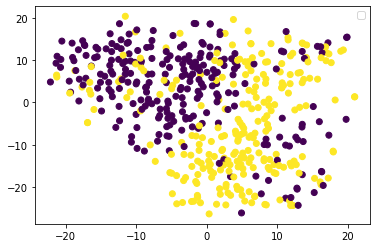

In [0]:
valX = np.load('valX.npy')
valY = np.load('valY.npy')

# ==============================================
#  我們示範 basline model 的作圖，
#  report 請同學另外還要再畫一張 improved model 的圖。
# ==============================================
model.load_state_dict(torch.load('./checkpoints/last_checkpoint.pth'))
model.eval()
latents = inference(valX, model)
pred_from_latent, emb_from_latent = predict(latents)
acc_latent = cal_acc(valY, pred_from_latent)
print('The clustering accuracy is:', acc_latent)
print('The clustering result:')
plot_scatter(emb_from_latent, valY, savefig='p1_baseline.png')



Problem 2
===
使用你 test accuracy 最高的 autoencoder，從 trainX 中，取出 index 1, 2, 3, 6, 7, 9 這 6 張圖片
畫出他們的原圖以及 reconstruct 之後的圖片。


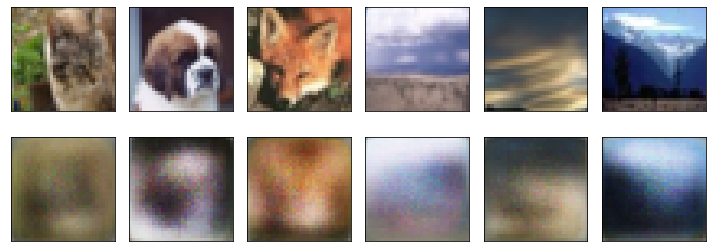

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# 畫出原圖
plt.figure(figsize=(10,4))
indexes = [1,2,3,6,7,9]
imgs = trainX[indexes,]
for i, img in enumerate(imgs):
    plt.subplot(2, 6, i+1, xticks=[], yticks=[])
    plt.imshow(img)

# 畫出 reconstruct 的圖
inp = torch.Tensor(trainX_preprocessed[indexes,]).cuda()
latents, recs = model(inp)
recs = ((recs+1)/2 ).cpu().detach().numpy()
recs = recs.transpose(0, 2, 3, 1)
for i, img in enumerate(recs):
    plt.subplot(2, 6, 6+i+1, xticks=[], yticks=[])
    plt.imshow(img)
  
plt.tight_layout()

Problem 3
===
在 autoencoder 的訓練過程中，至少挑選 10 個 checkpoints 
請用 model 的 train reconstruction error 對 val accuracy 作圖
簡單說明你觀察到的現象


In [0]:
import glob
checkpoints_list = sorted(glob.glob('checkpoints/checkpoint_*.pth'))

# load data
dataset = Image_Dataset(trainX_preprocessed)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

points = []
with torch.no_grad():
    for i, checkpoint in enumerate(checkpoints_list):
        print('[{}/{}] {}'.format(i+1, len(checkpoints_list), checkpoint))
        model.load_state_dict(torch.load(checkpoint))
        model.eval()
        err = 0
        n = 0
        for x in dataloader:
            x = x.cuda()
            _, rec = model(x)
            err += torch.nn.MSELoss(reduction='sum')(x, rec).item()
            n += x.flatten().size(0)
        print('Reconstruction error (MSE):', err/n)
        latents = inference(X=valX, model=model)
        pred, X_embedded = predict(latents)
        acc = cal_acc(valY, pred)
        print('Accuracy:', acc)
        points.append((err/n, acc))



[1/10] checkpoints/checkpoint_10.pth
Reconstruction error (MSE): 0.091790667627372
Latents Shape: (500, 4096)
First Reduction Shape: (500, 200)
Second Reduction Shape: (500, 2)
Accuracy: 0.532
[2/10] checkpoints/checkpoint_100.pth
Reconstruction error (MSE): 0.04701892385295793
Latents Shape: (500, 4096)
First Reduction Shape: (500, 200)
Second Reduction Shape: (500, 2)
Accuracy: 0.722
[3/10] checkpoints/checkpoint_20.pth
Reconstruction error (MSE): 0.07621818078732959
Latents Shape: (500, 4096)
First Reduction Shape: (500, 200)
Second Reduction Shape: (500, 2)
Accuracy: 0.694
[4/10] checkpoints/checkpoint_30.pth
Reconstruction error (MSE): 0.06828815650939941
Latents Shape: (500, 4096)
First Reduction Shape: (500, 200)
Second Reduction Shape: (500, 2)
Accuracy: 0.576
[5/10] checkpoints/checkpoint_40.pth
Reconstruction error (MSE): 0.06251474163579006
Latents Shape: (500, 4096)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


First Reduction Shape: (500, 200)
Second Reduction Shape: (500, 2)
Accuracy: 0.696
[6/10] checkpoints/checkpoint_50.pth
Reconstruction error (MSE): 0.05857664684220856
Latents Shape: (500, 4096)
First Reduction Shape: (500, 200)
Second Reduction Shape: (500, 2)
Accuracy: 0.644
[7/10] checkpoints/checkpoint_60.pth
Reconstruction error (MSE): 0.05553723170710545
Latents Shape: (500, 4096)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


First Reduction Shape: (500, 200)
Second Reduction Shape: (500, 2)
Accuracy: 0.734
[8/10] checkpoints/checkpoint_70.pth
Reconstruction error (MSE): 0.05297665315515855
Latents Shape: (500, 4096)
First Reduction Shape: (500, 200)
Second Reduction Shape: (500, 2)
Accuracy: 0.682
[9/10] checkpoints/checkpoint_80.pth
Reconstruction error (MSE): 0.051267594879748773
Latents Shape: (500, 4096)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


First Reduction Shape: (500, 200)
Second Reduction Shape: (500, 2)
Accuracy: 0.76
[10/10] checkpoints/checkpoint_90.pth
Reconstruction error (MSE): 0.048887370689242496
Latents Shape: (500, 4096)
First Reduction Shape: (500, 200)
Second Reduction Shape: (500, 2)
Accuracy: 0.71


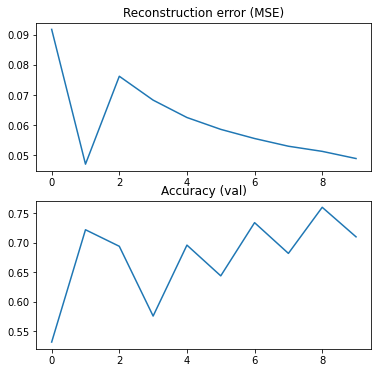

In [0]:
ps = list(zip(*points))
plt.figure(figsize=(6,6))
plt.subplot(211, title='Reconstruction error (MSE)').plot(ps[0])
plt.subplot(212, title='Accuracy (val)').plot(ps[1])
plt.show()